# Model Definition and Evaluation
## Table of Contents
1. [Libraries](#libraries)
2. [Load dataset](#load-dataset)
3. [Model configuration](#model-configuration)
4. [Implementation](#implementation)
5. [Evaluation](#evaluation)


## 1. Libraries

In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 6.5 MB/s eta 0:00:00


In [17]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report, mean_absolute_error
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

## 2. Load dataset

Load a preprocessed data and select features.

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Load the dataset
# Replace 'your_dataset.csv' with the path to your actual dataset
df = pd.read_csv('/content/drive/MyDrive/opencampus_all_files/combined_data_r1.csv')

# Feature and target variable selection
Time_real = df['Time']
X = df[['Elevation', 'Slope_prev', 'Slope_next',  'Angle', 'Distance', 'Cumulative_Slope']] # Cumulative slope
y = df['Speed']

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)


## 3. Model configuration


In [6]:
# Initialize the model
model = Sequential()

# Input Layer (6 features)
model.add(Dense(128, input_dim=X_train.shape[1], activation='relu'))

# Hidden Layers
model.add(Dense(256, activation='relu'))  # Large hidden layer to capture more complex patterns
model.add(Dropout(0.2))  # Dropout to prevent overfitting
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))  # Dropout again after each hidden layer

# Output Layer
model.add(Dense(1))  # Regression output

# Compile the model
model.compile(optimizer=Adam(), loss='mean_squared_error', metrics=['mae'])

# Summarize the model architecture
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               896       
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66945 (261.50 KB)
Trainable params: 66945 

In [8]:
# 1. Early Stopping: Stops training when validation loss doesn't improve.
early_stopping = EarlyStopping(
    monitor='val_loss',       # Metric to monitor
    patience=10,              # Number of epochs to wait for improvement
    restore_best_weights=True # Rollback to the best model weights
)

# 2. Model Checkpoint: Saves the best model during training.
model_checkpoint = ModelCheckpoint(
    'nn_best_model.keras',     # Filepath to save the model
    monitor='val_loss',        # Metric to monitor
    save_best_only=True,       # Save only the best model
    mode='min',                # Minimize validation loss
    verbose=1                  # Show a message when saving the model
)

# 3. Learning Rate Scheduler: Reduce learning rate when validation loss plateaus.
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',        # Metric to monitor
    factor=0.1,                # Factor by which to reduce the learning rate
    patience=5,                # Number of epochs to wait before reducing
    min_lr=1e-6,               # Lower bound for learning rate
    verbose=1                  # Show a message when reducing the learning rate
)

# Combine callbacks into a list
callbacks = [early_stopping, model_checkpoint, reduce_lr]

## 4. Implementation



In [11]:
# Normalize the features using StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Epoch 1/100
121966/121996 [============================>.] - ETA: 0s - loss: 5.9130 - mae: 1.7073
Epoch 1: val_loss improved from inf to 5.41552, saving model to nn_best_model.keras
121996/121996 [==============================] - 165s 1ms/step - loss: 5.9128 - mae: 1.7073 - val_loss: 5.4155 - val_mae: 1.6272 - lr: 0.0010
Epoch 2/100
121981/121996 [============================>.] - ETA: 0s - loss: 5.4845 - mae: 1.6294
Epoch 2: val_loss improved from 5.41552 to 5.25887, saving model to nn_best_model.keras
121996/121996 [==============================] - 164s 1ms/step - loss: 5.4845 - mae: 1.6294 - val_loss: 5.2589 - val_mae: 1.5903 - lr: 0.0010
Epoch 3/100
121981/121996 [============================>.] - ETA: 0s - loss: 5.3520 - mae: 1.6036
Epoch 3: val_loss improved from 5.25887 to 5.12287, saving model to nn_best_model.keras
121996/121996 [==============================] - 163s 1ms/step - loss: 5.3520 - mae: 1.6036 - val_loss: 5.1229 - val_mae: 1.5572 - lr: 0.0010
Epoch 4/100
121985/1

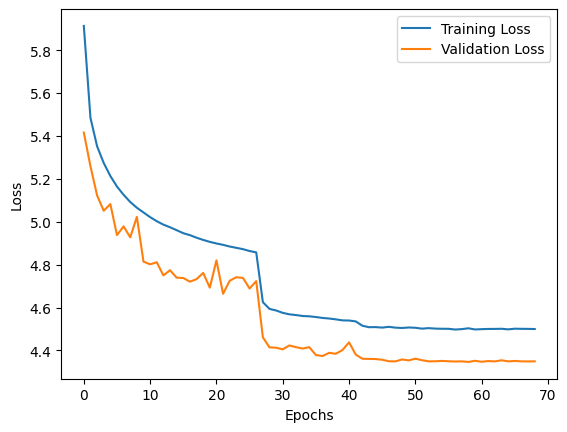

In [12]:
# Train the model with callbacks
history = model.fit(
    X_train_scaled, y_train,
    epochs=100,
    batch_size=32,
    validation_data=(X_test_scaled, y_test),
    callbacks=callbacks       # Pass callbacks to the fit method
)

# Evaluate the model
loss, mae = model.evaluate(X_test_scaled, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")

# Optionally, plot the training history (e.g., loss or MAE over epochs)
import matplotlib.pyplot as plt
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()



## 5. Evaluation

Comparison between linear and neural network model.


#### Load test files

In [14]:
# unzip test files
!unzip /content/drive/MyDrive/opencampus_all_files/Rider1_test.zip -d /content

Archive:  /content/drive/MyDrive/opencampus_all_files/Rider1_test.zip
   creating: /content/content/Rider1_test/
  inflating: /content/content/Rider1_test/f729.csv  
  inflating: /content/content/Rider1_test/f573.csv  
  inflating: /content/content/Rider1_test/f274.csv  
  inflating: /content/content/Rider1_test/f15.csv  
  inflating: /content/content/Rider1_test/f70.csv  
  inflating: /content/content/Rider1_test/f358.csv  
  inflating: /content/content/Rider1_test/f196.csv  
  inflating: /content/content/Rider1_test/f737.csv  
  inflating: /content/content/Rider1_test/f540.csv  
  inflating: /content/content/Rider1_test/f434.csv  


#### Evaluation 1 - Linear Regression

In [15]:
# Load linear model
lr_model = joblib.load('/content/drive/MyDrive/opencampus_all_files/models/r1_init_lr_model.joblib')

In [18]:
# Define the folder containing the files
input_folder_path = '/content/content/Rider1_test/'
output_folder_path = '/content/content/Rider1_test_LR/'

# Create output_folder_path
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# List all CSV files in the folder
csv_files = [f for f in os.listdir(input_folder_path) if f.endswith('.csv')]

# Iterate through each file in the folder
for file in csv_files:
    file_path = os.path.join(input_folder_path, file)

    # Read test file
    df = pd.read_csv(file_path)

    # Feature selection
    real_time = df['Time']
    X = df[['Elevation', 'Slope_prev', 'Slope_next', 'Angle', 'Distance', 'Cumulative_Slope']]
    y = df['Speed']

    # Make predictions on the new data
    y_pred = lr_model.predict(X)

    # Add the predicted values as a new column 'Speed_pred' in the original DataFrame
    df['Speed_pred'] = y_pred

    # Calculate MAE between df['Speed_pred'] and df['Speed']
    mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
    print(f"File: {file} | Mean Absolute Error: {mae}")

    # Initialize Time column
    df['Time_pred'] = float(df['Time'].iloc[0])

    # Compute predicted time
    for i in range(2, len(df)):
        if df.loc[i, 'Speed_pred'] < 0:
            df.loc[i, 'Speed_pred'] = 0
        if pd.notna(df.loc[i, 'Speed_pred']):
            if df.loc[i, 'Speed_pred'] != 0:
                df.loc[i, 'Time_pred'] = (
                    df.loc[i - 1, 'Time_pred'] +
                    (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
                )
            else:
                df.loc[i, 'Time_pred'] = df.loc[i - 1, 'Time_pred']

    # Save the processed DataFrame to a new file (optional)
    output_file_path = os.path.join(output_folder_path, f"lr_{file}")
    df.to_csv(output_file_path, index=False)


File: f729.csv | Mean Absolute Error: 3.7590308974823663
File: f573.csv | Mean Absolute Error: 3.023838732251371
File: f274.csv | Mean Absolute Error: 2.990506993991007
File: f15.csv | Mean Absolute Error: 4.369134090674801
File: f70.csv | Mean Absolute Error: 4.585313688421683
File: f358.csv | Mean Absolute Error: 2.2341906067906083
File: f196.csv | Mean Absolute Error: 2.018804913641264
File: f737.csv | Mean Absolute Error: 1.9240215480755247
File: f540.csv | Mean Absolute Error: 3.665805771576365
File: f434.csv | Mean Absolute Error: 2.437380576433266


#### Evaluation 2 - Neural Network

In [19]:
# Load linear model
nn_model = tf.keras.models.load_model('/content/drive/MyDrive/opencampus_all_files/models/r1_best_nn_model.keras')

In [20]:
# Define the folder containing the files
input_folder_path = '/content/content/Rider1_test/'
output_folder_path = '/content/content/Rider1_test_NN/'

# Create output_folder_path
if not os.path.exists(output_folder_path):
    os.makedirs(output_folder_path)

# List all CSV files in the folder
csv_files = [f for f in os.listdir(input_folder_path) if f.endswith('.csv')]

# Iterate through each file in the folder
for file in csv_files:
    file_path = os.path.join(input_folder_path, file)

    # Read test file
    df = pd.read_csv(file_path)

    # Feature selection
    real_time = df['Time']
    X = df[['Elevation', 'Slope_prev', 'Slope_next', 'Angle', 'Distance', 'Cumulative_Slope']]
    y = df['Speed']

    # Make predictions on the new data
    X_new_scaled = scaler.transform(X)
    y_pred = nn_model.predict(X_new_scaled)

    # Add the predicted values as a new column 'Speed_pred' in the original DataFrame
    df['Speed_pred'] = y_pred

    # Calculate MAE between df['Speed_pred'] and df['Speed']
    mae = mean_absolute_error(df['Speed'], df['Speed_pred'])
    print(f"File: {file} | Mean Absolute Error: {mae}")

    # Initialize Time column
    df['Time_pred'] = float(df['Time'].iloc[0])

    # Compute predicted time
    for i in range(2, len(df)):
        if df.loc[i, 'Speed_pred'] < 0:
            df.loc[i, 'Speed_pred'] = 0
        if pd.notna(df.loc[i, 'Speed_pred']):
            if df.loc[i, 'Speed_pred'] != 0:
                df.loc[i, 'Time_pred'] = (
                    df.loc[i - 1, 'Time_pred'] +
                    (df.loc[i, 'Distance'] - df.loc[i - 1, 'Distance']) / df.loc[i, 'Speed_pred']
                )
            else:
                df.loc[i, 'Time_pred'] = df.loc[i - 1, 'Time_pred']

    # Save the processed DataFrame to a new file (optional)
    output_file_path = os.path.join(output_folder_path, f"nn_{file}")
    df.to_csv(output_file_path, index=False)


113/113 [==============================] - 0s 733us/step
File: f729.csv | Mean Absolute Error: 1.9640048754557657
27/27 [==============================] - 0s 748us/step
File: f573.csv | Mean Absolute Error: 2.33422941750691
137/137 [==============================] - 0s 743us/step
File: f274.csv | Mean Absolute Error: 2.231364139427358
45/45 [==============================] - 0s 712us/step
File: f15.csv | Mean Absolute Error: 2.9045932467843705
59/59 [==============================] - 0s 717us/step
File: f70.csv | Mean Absolute Error: 2.2105558923946944
239/239 [==============================] - 0s 715us/step
File: f358.csv | Mean Absolute Error: 1.2407014579102085
72/72 [==============================] - 0s 767us/step
File: f196.csv | Mean Absolute Error: 1.6722027774969703
61/61 [==============================] - 0s 794us/step
File: f737.csv | Mean Absolute Error: 1.86628655022557
86/86 [==============================] - 0s 798us/step
File: f540.csv | Mean Absolute Error: 1.4723059086

### Evaluation summary

In [21]:
# Summary statistics for processed files
output_folder_path = '/content/content/Rider1_test_LR/'
summary_lr = []
processed_files = [f for f in os.listdir(output_folder_path) if f.endswith('.csv')]

for file in processed_files:
    file_path = os.path.join(output_folder_path, file)
    df = pd.read_csv(file_path)

    # Extract the last value of 'Time' and 'Time_pred'
    last_time = df['Time'].iloc[-1]
    last_time_pred = df['Time_pred'].iloc[-1]

    # Calculate percentage difference
    percentage_diff = ((last_time_pred - last_time) / last_time) * 100 if last_time != 0 else None

    # Append to summary
    summary_lr.append({
        'file': file,
        'last_time': last_time,
        'last_time_pred': last_time_pred,
        'percentage_diff': percentage_diff
    })

In [22]:
# Summary statistics for processed files
output_folder_path = '/content/content/Rider1_test_NN/'
summary_nn = []
processed_files = [f for f in os.listdir(output_folder_path) if f.endswith('.csv')]

for file in processed_files:
    file_path = os.path.join(output_folder_path, file)
    df = pd.read_csv(file_path)

    # Extract the last value of 'Time' and 'Time_pred'
    last_time = df['Time'].iloc[-1]
    last_time_pred = df['Time_pred'].iloc[-1]

    # Calculate percentage difference
    percentage_diff = ((last_time_pred - last_time) / last_time) * 100 if last_time != 0 else None

    # Append to summary
    summary_nn.append({
        'file': file,
        'last_time': last_time,
        'last_time_pred': last_time_pred,
        'percentage_diff': percentage_diff
    })

In [25]:
# Print summary
summary_lr_df = pd.DataFrame(summary_lr).sort_values(by=['file'])
print(summary_lr_df)
print(f"Absolute percentage difference in LR model: {summary_lr_df['percentage_diff'].abs().mean()}\n")

summary_nn_df = pd.DataFrame(summary_nn).sort_values(by=['file'])
print(summary_nn_df)
print(f"Absolute percentage difference in NN model: {summary_nn_df['percentage_diff'].abs().mean()}")

          file  last_time  last_time_pred  percentage_diff
2   lr_f15.csv       3468     4891.403847        41.043940
4  lr_f196.csv       6416     6652.877966         3.691988
5  lr_f274.csv       4918     5689.160556        15.680369
9  lr_f358.csv      13207    13835.069860         4.755583
1  lr_f434.csv      18232    15334.294793       -15.893513
3  lr_f540.csv       5786     4061.035690       -29.812726
0  lr_f573.csv       1322     1214.018365        -8.168051
6   lr_f70.csv       4001     1309.591636       -67.268392
8  lr_f729.csv       3734     1937.769505       -48.104727
7  lr_f737.csv       1979     2126.388820         7.447641
Absolute percentage difference in LR model: 24.186693000542977

          file  last_time  last_time_pred  percentage_diff
1   nn_f15.csv       3468     4036.899984        16.404267
0  nn_f196.csv       6416     6497.516846         1.270524
7  nn_f274.csv       4918     5065.703712         3.003329
5  nn_f358.csv      13207    13440.777126         1